In [1]:
import os
os.chdir('..')
import pandas as pd
import glob
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from xml.etree import ElementTree as ET

from PIL import Image
import cv2

In [2]:
from effdet import EfficientDet, DetBenchTrain, get_efficientdet_config
from effdet.config.model_config import efficientdet_model_param_dict
from effdet.efficientdet import HeadNet
import timm

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler

In [4]:
import pytorch_lightning as pl
from pytorch_lightning.core.decorators import auto_move_data
from ensemble_boxes import ensemble_boxes_wbf
from fastcore.dispatch import typedispatch
from typing import List

# Data conversion
- Convert all xml files to a pandas dataframe for easier reuse

In [5]:
def convert_annots(annotations_path: str) -> pd.DataFrame:
    """
    Function to convert xml of annotations to a dataframe for easier processing
    Args:
        annots: a list of string file paths
        image_dir: path to the image folder
        
    Returns: a daframe containing xy, height, width, and label class
    """
    
    annotations = glob.glob(os.path.join(annotations_path, '*.xml'))
    data = {
        'image_path': [],
        'xmin': [],
        'ymin': [],
        'xmax': [],
        'ymax': [],
        'labels': []
    }
    
    for annot in annotations:
        tree = ET.parse(annot)
        root = tree.getroot()
        file_name = root.find('filename').text
        image_path = glob.glob(os.path.join(annotations_path, file_name))[0]
        
        for obj in root.findall('object'):
            data['image_path'].append(image_path)
            data['labels'].append(obj.find('name').text)
            for bb in obj.find('bndbox'):
                data[bb.tag].append(int(bb.text))
                
                
    return pd.DataFrame(data)

In [6]:
train_df = convert_annots('data/archive/train_zip/train/')
test_df = convert_annots('data/archive/test_zip/test/')

# Dataset adaptor
- A class that will convert images to the correct format

In [7]:
import utils

In [8]:
class FruitDatasetAdaptor(object):
    def __init__(self, annot_df):
        self.annot_df = annot_df
        self.labels = {
            'orange': 0,
            'banana': 1,
            'apple': 2
        }
        
    def __len__(self):
        return self.annot_df.shape[0]
    
    def get_image_and_labels_by_idx(self, index):
        annot = self.annot_df.iloc[index]
        image_path = annot['image_path']
        
        img = cv2.imread(image_path)
        pascal_bboxes = self.annot_df[self.annot_df['image_path'] == image_path][
            ["xmin", "ymin", "xmax", "ymax"]
        ].values
        class_labels = self.annot_df[self.annot_df['image_path'] == image_path]['labels'].values
        class_labels = [self.labels[class_label] for class_label in class_labels]
        return img, pascal_bboxes, class_labels, index
    
    def show_image(self, index):
        image, bboxes, class_labels, image_id = self.get_image_and_labels_by_idx(index)
        print(f"image_id: {image_id}")
        utils.show_image(image, bboxes.tolist(), class_labels)

In [9]:
train_ds = FruitDatasetAdaptor(train_df)
test_ds = FruitDatasetAdaptor(test_df)

image_id: 1


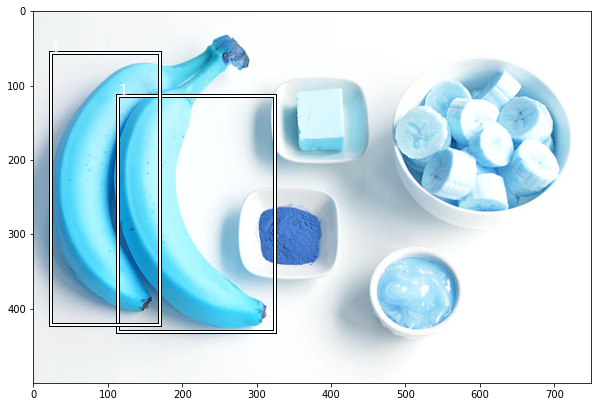

In [10]:
test_ds.show_image(1)

# Build and prepare dataloader

In [11]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [12]:
def get_train_transforms(target_img_size=512):
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Resize(height=target_img_size, width=target_img_size, p=1),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ToTensorV2(p=1)
    ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        )
    )

def get_valid_transforms(target_img_size=512):
    return A.Compose([
        A.Resize(height=target_img_size, width=target_img_size, p=1),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ToTensorV2(p=1)
    ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        )
    )

In [13]:
class EfficientDetDataset(Dataset):
    def __init__(
        self, dataset_adaptor, 
        transforms=get_valid_transforms()
    ):
        super(EfficientDetDataset, self).__init__()
        self.ds = dataset_adaptor
        self.transforms = transforms
        
    def __getitem__(self, index):
        (
            image, pascal_bboxes, 
            class_labels, image_id
        ) = self.ds.get_image_and_labels_by_idx(index)

        sample = {
            'image': image.astype(np.float32),
            'bboxes': pascal_bboxes,
            'labels': class_labels
        }
        
        sample = self.transforms(**sample)
        sample['bboxes'] = np.array(sample['bboxes'])
        image = sample["image"]
        pascal_bboxes = sample["bboxes"]
        labels = sample["labels"]
        
        _, new_h, new_w = image.shape
        sample["bboxes"][:, [0, 1, 2, 3]] = sample["bboxes"][
            :, [1, 0, 3, 2]
        ]  # convert to yxyx
        
        target = {
            "bboxes": torch.as_tensor(pascal_bboxes, dtype=torch.float32),
            "labels": torch.as_tensor(labels),
            "image_id": torch.tensor([image_id]),
            "img_size": (new_h, new_w),
            "img_scale": torch.tensor([1.0])
        }
        
        return image, target, image_id
        
    def __len__(self):
        return len(self.ds)

In [14]:
image, target, image_id = next(iter(EfficientDetDataset(train_ds)))

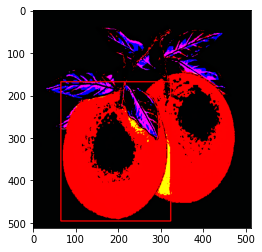

In [15]:
img = image.numpy().astype(np.uint8).transpose(1, 2, 0)
bbox = target['bboxes'][0].numpy().astype(np.int)
cv2.rectangle(img, (bbox[1], bbox[0]), (bbox[3], bbox[2]), (255, 0, 0), 2);

plt.imshow(img)

# Define data module

In [16]:
class EffcientDetDataModule(pl.LightningDataModule):
    def __init__(
        self, 
        train_dataset_adaptor, validation_dataset_adaptor,
        train_transforms=get_train_transforms(target_img_size=512), valid_transforms=get_valid_transforms(target_img_size=512),
        num_workers=4, batch_size=8
    ):
        super(EffcientDetDataModule, self).__init__()
        self.train_ds = train_dataset_adaptor
        self.valid_ds = validation_dataset_adaptor
        self.train_tfms = train_transforms
        self.valid_tfms = valid_transforms
        self.num_workers = num_workers
        self.batch_size = batch_size
        
    def train_dataset(self) -> EfficientDetDataset:
        return EfficientDetDataset(
            dataset_adaptor=self.train_ds, transforms=self.train_tfms
        )
    
    def train_dataloader(self) -> DataLoader:
        train_dataset = self.train_dataset()
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            drop_last=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn
        )
        
        return train_loader
    
    def val_dataset(self) -> EfficientDetDataset:
        return EfficientDetDataset(
            dataset_adaptor=self.valid_ds, transforms=self.valid_tfms
        )

    def val_dataloader(self) -> DataLoader:
        valid_dataset = self.val_dataset()
        valid_loader = DataLoader(
            valid_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            pin_memory=True,
            drop_last=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )

        return valid_loader
    
    @staticmethod
    def collate_fn(batch):
        images, targets, image_ids = tuple(zip(*batch))
        images = torch.stack(images)
        images = images.float()

        boxes = [target["bboxes"].float() for target in targets]
        labels = [target["labels"].float() for target in targets]
        img_size = torch.tensor([target["img_size"] for target in targets]).float()
        img_scale = torch.tensor([target["img_scale"] for target in targets]).float()

        annotations = {
            "bbox": boxes,
            "cls": labels,
            "img_size": img_size,
            "img_scale": img_scale,
        }

        return images, annotations, targets, image_ids

# Model creation

In [17]:
def create_model(
    num_classes=3, image_size=512, architecture="tf_efficientnetv2_l"
):
    efficientdet_model_param_dict['tf_efficientnetv2_l'] = dict(
        name='tf_efficientnetv2_l',
        backbone_name='tf_efficientnetv2_l',
        backbone_args=dict(drop_path_rate=0.2),
        num_classes=num_classes,
        url='', )
    
    config = get_efficientdet_config(architecture)
    config.update({'num_classes': num_classes})
    config.update({'image_size': (image_size, image_size)})
    
    print(config)
    
    net = EfficientDet(config, pretrained_backbone=True)
    net.class_net = HeadNet(
        config, num_outputs=config.num_classes
    )
    return DetBenchTrain(net, config)

# Define training loop

In [18]:
def run_wbf(predictions, image_size=512, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    bboxes = []
    confidences = []
    class_labels = []
    
    for prediction in predictions:
        boxes = [(prediction["boxes"] / image_size).tolist()]
        scores = [prediction["scores"].tolist()]
        labels = [prediction["classes"].tolist()]
        
        boxes, scores, labels = ensemble_boxes_wbf.weighted_boxes_fusion(
            boxes, scores, labels,
            weights=weights, iou_thr=iou_thr,
            skip_box_thr=skip_box_thr
        )
        boxes = boxes * (image_size - 1)
        bboxes.append(boxes.tolist())
        confidences.append(scores.tolist())
        class_labels.append(labels.tolist())
        
    return bboxes, confidences, class_labels

In [19]:
class EfficientDetModel(pl.LightningModule):
    def __init__(
        self,
        num_classes=3,
        img_size=512,
        prediction_confidence_threshold=0.2,
        learning_rate=0.0002,
        wbf_iou_threshold=0.44,
        inference_transforms=get_valid_transforms(target_img_size=512),
        model_architecture='tf_efficientnetv2_l',
    ):
        super(EfficientDetModel, self).__init__()
        self.img_size = img_size
        self.model = create_model(
            num_classes, img_size, architecture=model_architecture
        )
        
        self.prediction_confidence_threshold = prediction_confidence_threshold
        self.lr = learning_rate
        self.wbf_iou_threshold = wbf_iou_threshold
        self.inference_tfms = inference_transforms
        
    @auto_move_data
    def forward(self, images, targets):
        return self.model(images, targets)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)
    
    def training_step(self, batch, batch_idx):
        images, annotations, _, image_ids = batch

        losses = self.model(images, annotations)

        logging_losses = {
            "class_loss": losses["class_loss"].detach(),
            "box_loss": losses["box_loss"].detach(),
        }

        self.log("train_loss", losses["loss"], on_step=True, on_epoch=True, prog_bar=True,
                 logger=True)
        self.log(
            "train_class_loss", losses["class_loss"], on_step=True, on_epoch=True, prog_bar=True,
            logger=True
        )
        self.log("train_box_loss", losses["box_loss"], on_step=True, on_epoch=True, prog_bar=True,
                 logger=True)

        return losses['loss']
    
    @torch.no_grad()
    def validation_step(self, batch, batch_idx):
        images, annotations, targets, image_ids = batch
        outputs = self.model(images, annotations)
        
        detections = outputs['detections']
        
        batch_predictions = {
            "predictions": detections,
            "targets": targets,
            "image_ids": image_ids
        }
        
        logging_losses = {
            "class_loss": outputs["class_loss"].detach(),
            "box_loss": outputs["box_loss"].detach(),
        }
        self.log("valid_loss", outputs["loss"], on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, sync_dist=True)
        self.log(
            "valid_class_loss", logging_losses["class_loss"], on_step=True, on_epoch=True,
            prog_bar=True, logger=True, sync_dist=True
        )
        self.log("valid_box_loss", logging_losses["box_loss"], on_step=True, on_epoch=True,
                 prog_bar=True, logger=True, sync_dist=True)
        
        return {
            'loss': outputs['loss'],
            'batch_predictions': batch_predictions
        }

In [20]:
dm = EffcientDetDataModule(
    train_ds, test_ds, num_workers=4, batch_size=2
)

In [21]:
effdet = EfficientDetModel(
    num_classes=3,
    img_size=512,
    model_architecture='tf_efficientnetv2_l'
)

{'name': 'tf_efficientnetv2_l', 'backbone_name': 'tf_efficientnetv2_l', 'backbone_args': {'drop_path_rate': 0.2}, 'backbone_indices': None, 'image_size': [512, 512], 'num_classes': 3, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': 'same', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 3, 'fpn_cell_repeats': 3, 'fpn_channels': 88, 'separable_conv': True, 'apply_resample_bn': True, 'conv_after_downsample': False, 'conv_bn_relu_pattern': False, 'use_native_resize_op': False, 'downsample_type': 'max', 'upsample_type': 'nearest', 'redundant_bias': True, 'head_bn_level_first': False, 'head_act_type': None, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'legacy_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'soft_nms': False, 'ma

In [22]:
trainer = pl.Trainer(
    gpus=[0], max_epochs=10, num_sanity_val_steps=1
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [23]:
trainer.fit(effdet, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params
----------------------------------------
0 | model | DetBenchTrain | 116 M 
----------------------------------------
116 M     Trainable params
0         Non-trainable params
116 M     Total params
467.626   Total estimated model params size (MB)


/home/superceed1/anaconda3/envs/py38torch17/lib/python3.8/site-packages/pytorch_lightning/core/step_result.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)


In [24]:
trainer.save_checkpoint('weights/effdet_l.ckpt')